# Model output (part 1)
-----
J. Potemra

April 2022

-----

In this notebook we will have a look at various model output.  These include forecast models run operationally (typically daily), reanalysis (run in "hindcast"), and climate models.

## 1. Wave forecast: compare to point

In this first example we will have a look at output from a region wave model that is run in forecast mode.  This model (SWAN) is run operationally by PacIOOS every day and provides a several day forecast of wave height, period and direction.  PacIOOS runs different domains, and here we will look at the Oahu grid.

We will compare the model to data measured _in situ_ by a near-shore wave buoy.  Some questions we can ask:

  1. how well does the model do at compared to this buoy?
  2. how "representative" is this point to other points?

### 1A. Wave model

The wave model is the Simulating WAves Nearshore (SWAN) regional wave model for Oahu.  The results can be obtained from the PacIOOS THREDDS server:

https://pae-paha.pacioos.hawaii.edu/thredds/catalog.html

Wave Model Output --> SWAN Oahu Regional Wave Model --> Best Time Series --> OPeNDAP

https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/swan_oahu/SWAN_Oahu_Regional_Wave_Model_best.ncd

### 1B. Buoy data

We will use data from the Waimea buoy (106).  The Coastal Data Information Program (CDIP) at Scripps maintains an archive of all the US buoy.  The Waimea page is

https://cdip.ucsd.edu/themes/cdip?d2=p70&u2=s:106:v:parameter

and the data are at Data --> Realtime --> OPeNDAP

http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/106p1_rt.nc

### 1C. Read in needed packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import netCDF4 as nc
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### 1D. Access data from the model (mod_) and buoy (obs_)

In [2]:
URL1 = 'https://pae-paha.pacioos.hawaii.edu/thredds/dodsC/swan_oahu/SWAN_Oahu_Regional_Wave_Model_best.ncd'
mod = nc.Dataset(URL1)

URL2 = 'http://thredds.cdip.ucsd.edu/thredds/dodsC/cdip/realtime/106p1_rt.nc'
obs = nc.Dataset(URL2)

In [3]:
mod

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    title: Simulating WAves Nearshore (SWAN) Regional Wave Model: Oahu
    _CoordSysBuilder: ucar.nc2.dataset.conv.CF1Convention
    Conventions: CF-1.6, ACDD-1.3
    cdm_data_type: Grid
    featureType: GRID
    location: Proto fmrc:SWAN_Oahu_Regional_Wave_Model
    id: swan_oahu
    naming_authority: org.pacioos
    metadata_link: http://pacioos.org/metadata/swan_oahu.html
    ISO_Topic_Categories: oceans
    summary: Simulating WAves Nearshore (SWAN) regional wave model 7-day output with a 5-day hourly forecast for the Hawaiian island of Oahu at approximately 500-m resolution. This high-resolution model is utilized to capture shallow water effects and nearshore coastal dynamics such as refracting, shoaling, and smaller scale shadowing. It is run directly after the Hawaii regional WaveWatch III (WW3) wave model (ww3_hawaii) has completed. Please note that some of the nested model setup is st

In [4]:
# The model produces output every three hours, so there are many
#   time-steps (60,000+); here we just access the last "N" times
#   pick N to be small otherwise it will take too long.
N = 300
mod_lat = mod.variables['lat'][:] 
mod_lon = mod.variables['lon'][:]
mod_wh = mod.variables['shgt'][-N:,0,:,:]

In [5]:
mod_wh

masked_array(
  data=[[[1.351050853729248, 1.3357657194137573, 1.3327603340148926,
          ..., 1.7873039245605469, 1.7893667221069336,
          1.7927649021148682],
         [1.3318458795547485, 1.2879561185836792, 1.2845357656478882,
          ..., 1.7901439666748047, 1.793721318244934, 1.800035834312439],
         [1.3177064657211304, 1.274865746498108, 1.2713428735733032,
          ..., 1.7975949048995972, 1.8013821840286255,
          1.8078221082687378],
         ...,
         [1.9511690139770508, 1.9431959390640259, 1.9427067041397095,
          ..., 2.0886600017547607, 2.090512275695801,
          2.0922482013702393],
         [1.9654664993286133, 1.9568660259246826, 1.9565374851226807,
          ..., 2.0914394855499268, 2.092505693435669, 2.093332052230835],
         [1.9798824787139893, 1.9781328439712524, 1.9776954650878906,
          ..., 2.0950167179107666, 2.094867467880249,
          2.0946197509765625]],

        [[1.3643198013305664, 1.3497061729431152, 1.3471024036

In [6]:
obs

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    naming_authority: edu.ucsd.cdip
    keywords_vocabulary: Global Change Master Directory (GCMD) Earth Science Keywords
    date_created: 2022-04-23T00:00:44Z
    date_issued: 2022-04-23T00:00:44Z
    date_modified: 2022-04-23T00:00:44Z
    creator_name: Coastal Data Information Program, SIO/UCSD
    creator_url: http://cdip.ucsd.edu
    creator_email: www@cdip.ucsd.edu
    publisher_name: Coastal Data Information Program, SIO/UCSD
    publisher_url: http://cdip.ucsd.edu
    publisher_email: www@cdip.ucsd.edu
    institution: Scripps Institution of Oceanography, University of California San Diego
    project: Coastal Data Information Program (CDIP)
    processing_level: QA/QC information available at http://cdip.ucsd.edu/documentation
    standard_name_vocabulary: CF Standard Name Table (v29, 08 July 2015)
    Conventions: ACDD-1.3, CF-1.6
    license: These data may be redistributed and use

In [7]:
obs_wh = obs.variables['waveHs'][:]

In [8]:
# like before, we convert time to DateTime

time_convert = nc.num2date(mod.variables['time'][-N:],
                           mod.variables['time'].units,
                          only_use_cftime_datetimes=False)
mod_time = pd.to_datetime(time_convert)

time_convert = nc.num2date(obs.variables['waveTime'],
                           obs.variables['waveTime'].units,
                          only_use_cftime_datetimes=False)
obs_time = pd.to_datetime(time_convert)

### 1E. Compare at a point closest to the buoy

In [9]:
buoy_lat = 21.6705
buoy_lon = -158.1171

J = np.argmin(np.abs( mod_lat - buoy_lat ) )
I = np.argmin(np.abs( (mod_lon-360.0) - buoy_lon) )

In [12]:
mod_lat[J],mod_lon[I]-360

(21.67, -158.11500549316406)

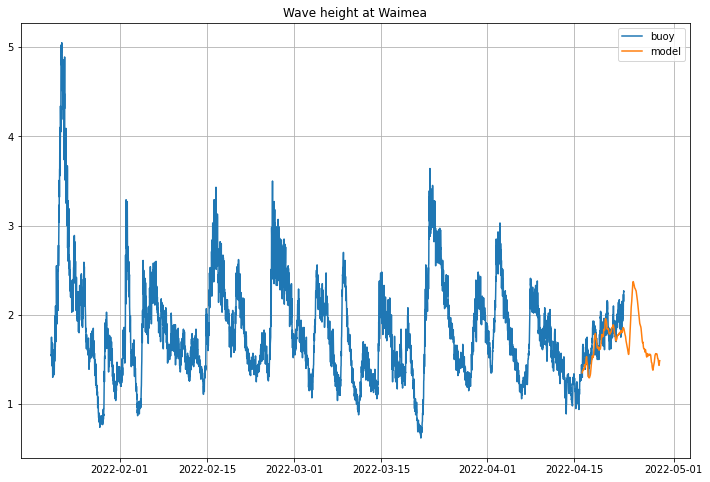

In [13]:
fig = plt.subplots(figsize=(12,8))
plt.plot(obs_time,obs_wh,label='buoy')
plt.plot(mod_time,mod_wh[:,J,I],label='model')
plt.legend()
plt.grid()
plt.title('Wave height at Waimea');

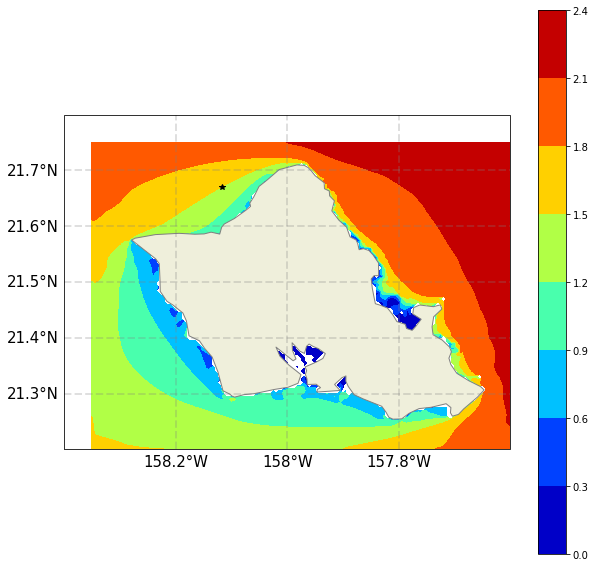

In [15]:
# plot the final forecast time
plt.figure(figsize=(10,10))

ax = plt.axes(projection = ccrs.PlateCarree())

land_50m = cf.NaturalEarthFeature('physical', 'land', '10m',
                                        edgecolor='face',
                                        facecolor=cf.COLORS['land'])
ax.add_feature(land_50m, edgecolor='gray')

ax.set_extent([-158.4, -157.6, 21.2, 21.8], crs=ccrs.PlateCarree())

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha = 0.25, linestyle='--')

# labels on bottom and left axes
gl.xlabels_top = False
gl.ylabels_right = False

# define the label style
gl.xlabel_style = {'size': 15, 'color': 'black'}
gl.ylabel_style = {'size': 15, 'color': 'black'}

# now we define exactly which ones to label and spruce up the labels
gl.xlocator = mticker.FixedLocator([-158.4, -158.2, -158.0, -157.8, -157.6])
#gl.ylocator = mticker.FixedLocator([21.2, 21.4, 21.6, 21.8])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

plt.contourf(mod_lon,mod_lat,mod_wh[-1,:,:],cmap=cm.jet,
             transform=ccrs.PlateCarree())
plt.plot(buoy_lon,buoy_lat,'k*')
#plt.colorbar(shrink=0.5);
plt.colorbar()

## 2. Investigating model output: future warming

In this example we will have a look at output from a coupled climate model to investigate, in a simple way, projected warming.  Here we can compare future temperatures to present from two different IPCC scenarios, RCP-4.5 and RCP-8.5.  We will use a single model (just because it is faster, but it is not necessarily the best thing to do scientifically speaking).  We will also, again for the sake of speed, estimate the change by taking the mean from the last year of the simluation and comparing it to the mean of the first year.

## But first... introduction to functions

Most languages, python included, make use of functions.  These are separate code blocks that perform some specific task.  It helps to write/use a function if you want to perform the same task over and over again (write once, use many).

The syntax for a python function is it starts with a definition line (_def_), the function name,  any arguments that will get passed to the function, and then finally a colon (:).  All the function code then gets properly and consistently indented, and the function ends with a return statement.  These functions are then "called" just like any other external function/package.

For example, let's define a function to add two numbers together (simple..., yes).  We'll call this function "sum2num" (always a good idea to use a name that, as far as you know, is unique so as not to confuse it with external functions).  The function will take two numbers (_a_ and _b_) as input, and then return the sum.

    def sum2num(a,b):
       c = a + b
       return c

The first line is our function definition, and it includes the name of the function and the arguments passed to it.  The subsequent lines are indented, and it ends with a return.

In [21]:
# my function to add two numbers together
#  the function takes two number as input
#  the fuction returns a single number
def sum2num(a,b):
    c = a + b
    return c

In [17]:
# now lets try it out
x = 4
y = 5
z = sum2num(x,y)
print(z)

9


In [18]:
print(sum2num(10,5))

15


This is a very simple example, and it might be easier to just add numbers rather than write a function.  In our scripts, we can think about things we do repeatedly, and maybe we want to put them into a function.  For example, we continually convert time using num2date, or we use the same map-plotting code block a lot.

## Climate model output

The APDRC (http://apdrc.soest.hawaii.edu) hosts a variety of climate model output from the CMIP-5 set of experiments.  Here we will look at the output from the GFDL model, and let's use the RCP-4.5 and RCP-8.5 experiments.  We will access the surface temperature, _tas_.

### 2A. Read in needed packages

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import netCDF4 as nc
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

### 2B. Access data from the model

In [23]:
URL1 = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp45/tas/GFDL-CM3_r1i1p1'
tas_r45 = nc.Dataset(URL1)

URL2 = 'http://apdrc.soest.hawaii.edu:80/dods/public_data/CMIP5/rcp85/tas/GFDL-CM3_r1i1p1'
tas_r85 = nc.Dataset(URL2)

### 2C. Extract lat/lon/time from model(s)

In [24]:
lat_r45 = tas_r45.variables['lat'][:] 
lon_r45 = tas_r45.variables['lon'][:]

lat_r85 = tas_r85.variables['lat'][:] 
lon_r85 = tas_r85.variables['lon'][:]

### 2D. Extract the first 12 months and last 12 months from each

In [25]:
tas1_r45 = tas_r45.variables['tas'][0:12,:,:]
tas2_r45 = tas_r45.variables['tas'][-12:,:,:]
tas1_r85 = tas_r85.variables['tas'][0:12,:,:]
tas2_r85 = tas_r85.variables['tas'][-12:,:,:]

In [26]:
print(tas1_r45.shape,tas2_r45.shape,tas1_r85.shape,tas2_r85.shape)

(12, 90, 144) (12, 90, 144) (12, 90, 144) (12, 90, 144)


### 2E. Compute the difference between the last year mean and first year

In [28]:
deltaT_r45 = tas2_r45.mean(axis=0) - tas1_r45.mean(axis=0)
deltaT_r85 = tas2_r85.mean(axis=0) - tas1_r85.mean(axis=0)

In [29]:
print(tas2_r45.shape,deltaT_r45.shape)

(12, 90, 144) (90, 144)


### 2F. Make plots

Text(0.5, 1.0, 'Temperature change from GFDL RCP-8.5')

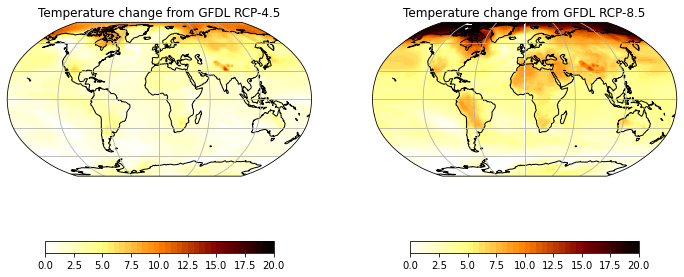

In [30]:
plt.figure(figsize=(12,8))

# first plot on the left:
ax1 = plt.subplot(1,2,1,projection=ccrs.Robinson(central_longitude=0))
ax1.gridlines()
ax1.add_feature(cf.COASTLINE)
clevs = np.linspace(0,20,41)
plt.contourf(lon_r45,lat_r45,deltaT_r45,levels=clevs,
             transform=ccrs.PlateCarree(),cmap=cm.afmhot_r)
plt.colorbar(orientation='horizontal',shrink=0.75)
plt.title('Temperature change from GFDL RCP-4.5')

# second plot on the left:
ax1 = plt.subplot(1,2,2,projection=ccrs.Robinson(central_longitude=0))
ax1.gridlines()
ax1.add_feature(cf.COASTLINE)
clevs = np.linspace(0,20,41)
plt.contourf(lon_r85,lat_r85,deltaT_r85,levels=clevs,transform=ccrs.PlateCarree(),cmap=cm.afmhot_r)
plt.colorbar(orientation='horizontal',shrink=0.75)
plt.title('Temperature change from GFDL RCP-8.5')